# Importing Dependencies and Dataset Preparation

In [1]:
!pip install kaggle
!pip install patool

     |████████████████████████████████| 81kB 4.1MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab import files

import os
import shutil
import patoolib
import warnings

print(tf.__version__)
warnings.filterwarnings('ignore')

2.5.0


In [3]:
tf.random.set_seed(666)

# Importing Kaggle Training and Validation Sets

Using /tmp to create a temporary folder

In [4]:
if not os.path.exists(os.getcwd() + "/kaggle.json"):
  files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tawsifurrahman/covid19-radiography-database

# extract riceleafs dataset
patoolib.extract_archive(os.getcwd() + "/covid19-radiography-database.zip", outdir = os.getcwd() + "/Dataset")
os.remove(os.getcwd() + "/covid19-radiography-database.zip")

Saving kaggle.json to kaggle.json
100% 745M/745M [00:07<00:00, 77.2MB/s]

patool: Extracting /content/covid19-radiography-database.zip ...
patool: running /usr/bin/7z x -o/content/Dataset -- /content/covid19-radiography-database.zip
patool: ... /content/covid19-radiography-database.zip extracted to `/content/Dataset'.


In [5]:
output_class = 2 # 2/3 class
if output_class > 3 or output_class < 2:
  print("Undefined")

if os.path.exists(os.getcwd() + "/Dataset/Preprocessing"):
  shutil.rmtree(os.getcwd() + "/Dataset/Preprocessing")
os.mkdir(os.getcwd() + "/Dataset/Preprocessing")

shutil.copytree(os.getcwd() + "/Dataset/COVID-19_Radiography_Dataset/COVID", os.getcwd() + "/Dataset/Preprocessing/COVID")
shutil.copytree(os.getcwd() + "/Dataset/COVID-19_Radiography_Dataset/Normal", os.getcwd() + "/Dataset/Preprocessing/Normal")
if output_class == 3:
    shutil.copytree(os.getcwd() + "/Dataset/COVID-19_Radiography_Dataset/Viral Pneumonia", os.getcwd() + "/Dataset/Preprocessing/Viral_Pneumonia")


# Data Preprocessing

In [6]:
data_dir = os.getcwd() + "/Dataset/Preprocessing"

In [7]:
# Directing Images to train folder
img_height, img_width = 128,128
batch_size = 16
train_datagen = ImageDataGenerator(validation_split = 0.3) # set validation split

if output_class == 2:
  train_generator = train_datagen.flow_from_directory(
      data_dir,
      target_size = (img_height, img_width),
      batch_size = batch_size,
      class_mode = "binary",
      subset = "training") # set as training data
  # Splitting images for validation set
  validation_generator = train_datagen.flow_from_directory(
      data_dir, # same directory as training data
      target_size = (img_height, img_width),
      batch_size = batch_size,
      class_mode = "binary",
      subset = "validation") # set as validation data

elif output_class == 3:
  train_generator = train_datagen.flow_from_directory(
      data_dir,
      target_size = (img_height, img_width),
      batch_size = batch_size,
      class_mode = "categorical",
      subset = "training") # set as training data
  # Splitting images for validation set
  validation_generator = train_datagen.flow_from_directory(
      data_dir, # same directory as training data
      target_size = (img_height, img_width),
      batch_size = batch_size,
      class_mode = "categorical",
      subset = "validation") # set as validation data
      
else:
  print("Undefined")

Found 9667 images belonging to 2 classes.
Found 4141 images belonging to 2 classes.


# Model Building

In [8]:
# Used Sequential
if output_class == 2:
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), activation = "relu", input_shape = (img_height, img_width, 3)),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Conv2D(64, (2, 2), activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Conv2D(128, (2, 2), activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = "relu"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(512, activation = "relu"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation = "sigmoid")],
      name = "CNN_Binary_Classification")
  
elif output_class == 3:
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), activation = "relu", input_shape = (img_height, img_width, 3)),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Conv2D(64, (2, 2), activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Conv2D(128, (2, 2), activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2), strides = None, padding = "valid"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = "relu"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(512, activation = "relu"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(3, activation = "softmax")], 
      name = "CNN_Categorical_Classification")
  
else:
  print("Undefined")

model.summary()

Model: "CNN_Binary_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800

In [9]:
# Defining optimizer
if output_class == 2:
  model.compile(optimizer = Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics = ["accuracy"])
  
elif output_class == 3:
  model.compile(optimizer = Adam(learning_rate = 0.0001),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  
else:
  print("Undefined")

In [10]:
# Training the model
trainer = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 30,
    verbose = 2)

Epoch 1/30
605/605 - 291s - loss: 0.9831 - accuracy: 0.7984 - val_loss: 0.2749 - val_accuracy: 0.8800
Epoch 2/30
605/605 - 290s - loss: 0.2278 - accuracy: 0.9072 - val_loss: 0.2716 - val_accuracy: 0.8911
Epoch 3/30
605/605 - 290s - loss: 0.1586 - accuracy: 0.9376 - val_loss: 0.1820 - val_accuracy: 0.9338
Epoch 4/30
605/605 - 289s - loss: 0.1228 - accuracy: 0.9529 - val_loss: 0.1819 - val_accuracy: 0.9377
Epoch 5/30
605/605 - 290s - loss: 0.0854 - accuracy: 0.9683 - val_loss: 0.3025 - val_accuracy: 0.9090
Epoch 6/30
605/605 - 291s - loss: 0.0625 - accuracy: 0.9761 - val_loss: 0.1935 - val_accuracy: 0.9430
Epoch 7/30
605/605 - 291s - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.1901 - val_accuracy: 0.9476
Epoch 8/30
605/605 - 290s - loss: 0.0444 - accuracy: 0.9855 - val_loss: 0.1764 - val_accuracy: 0.9522
Epoch 9/30
605/605 - 292s - loss: 0.0317 - accuracy: 0.9883 - val_loss: 0.2203 - val_accuracy: 0.9411
Epoch 10/30
605/605 - 291s - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.2457 - 

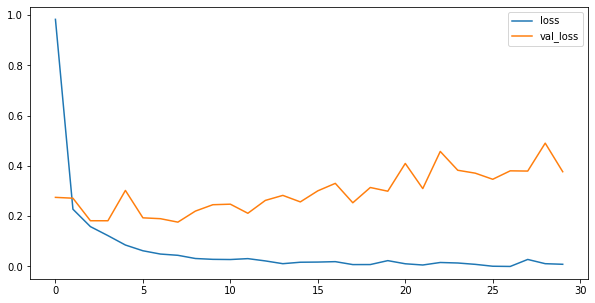

In [11]:
# Plotting train_loss vs val_loss
plt.figure(figsize = (10, 5))
plt.plot(trainer.history["loss"], label = "loss")
plt.plot(trainer.history["val_loss"], label = "val_loss")
plt.legend()

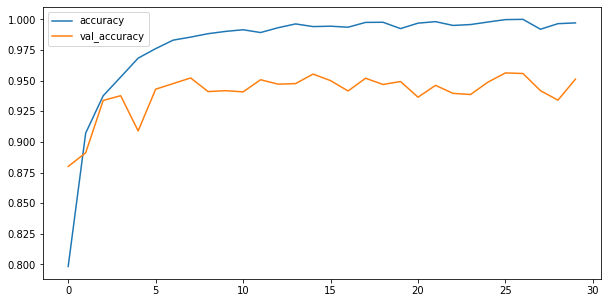

In [12]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(trainer.history["accuracy"], label = "accuracy")
plt.plot(trainer.history["val_accuracy"], label = "val_accuracy")
plt.legend(loc = 'upper left')